# 95767 Cybersecurity for Artificial Intelligence & Machine Learning

## Assignment 2

### 150 points 

### Name: Smridhi Patwari (smridhip)

In this assignment, you will be conducting adversarial ML (AML) attacks against a target model. Next week, we will implement methods for defending against AML attacks.

The dataset used in this assignment is a classic machine learning dataset. It contains data on 3 plant species. The features we will be using are sepal length and width, and petal length and width.

In [422]:
# Import packages
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import copy

In [423]:
# Read in the dataset (downloaded from Assigments folder)
df = pd.read_csv("iris_extended.csv")

In [424]:
# Take a look at the data
print(df.head())
print(df.columns)
print(df.shape)

  species  elevation soil_type  sepal_length  sepal_width  petal_length  \
0  setosa      161.8     sandy          5.16         3.41          1.64   
1  setosa      291.4      clay          5.48         4.05          1.53   
2  setosa      144.3     sandy          5.10         2.80          1.47   
3  setosa      114.6      clay          4.64         3.44          1.53   
4  setosa      110.9     loamy          4.85         2.87          1.23   

   petal_width  sepal_area  petal_area  sepal_aspect_ratio  ...  \
0         0.26     17.5956      0.4264            1.513196  ...   
1         0.37     22.1940      0.5661            1.353086  ...   
2         0.38     14.2800      0.5586            1.821429  ...   
3         0.17     15.9616      0.2601            1.348837  ...   
4         0.26     13.9195      0.3198            1.689895  ...   

   sepal_to_petal_length_ratio  sepal_to_petal_width_ratio  \
0                     3.146341                   13.115385   
1                     

Below we will separate training and testing data. The training data is used to train the model. We will use the testing data to evaluate the model's performance in production.

In [425]:
# This code randomly selects some data to be the training data and some to be the test/production data.
np.random.seed(1)
training_rows = np.random.choice(df.index, size=1000, replace=False)
test_rows = df.index.difference(training_rows)

train_df = df.loc[training_rows]
test_df = df.loc[test_rows]
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

Let's take a look at the differences in the features between the species. (Hint: you may want to refer to these plots when answering some of the coding or free-response assignment questions).

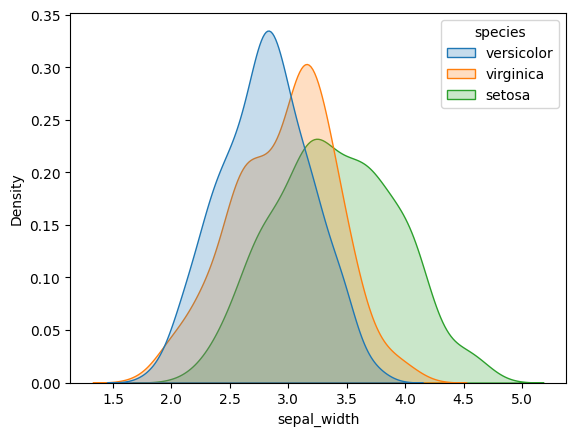

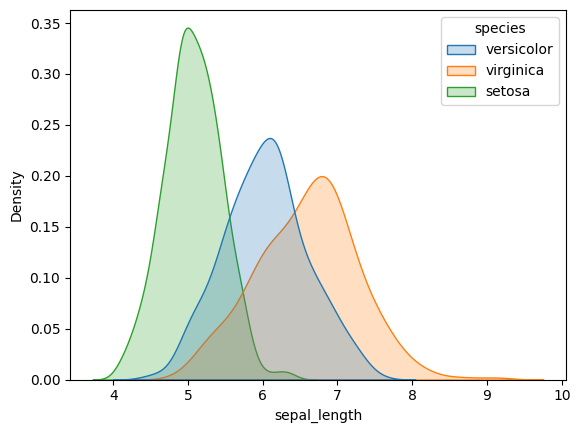

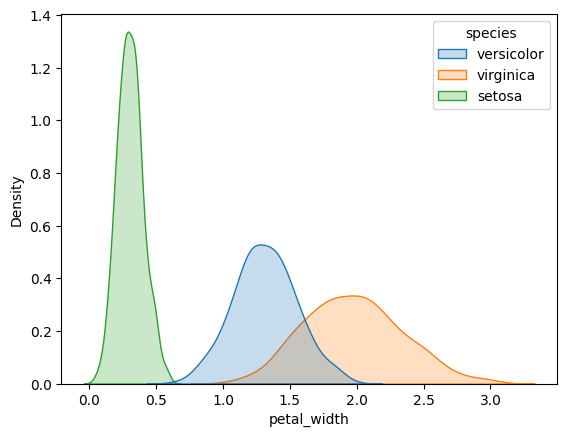

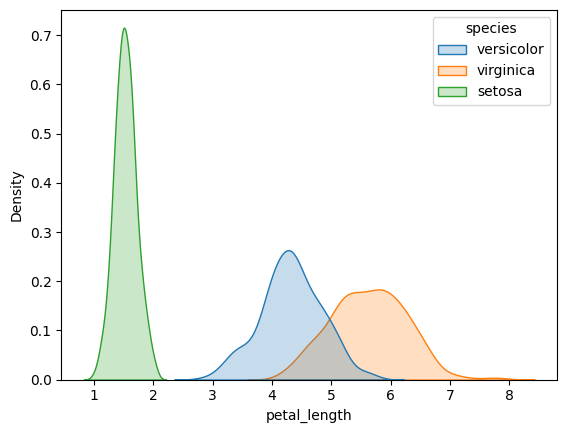

In [426]:
sns.kdeplot(data=train_df, x="sepal_width", hue="species", fill=True)
plt.show()
sns.kdeplot(data=train_df, x="sepal_length", hue="species", fill=True)
plt.show()
sns.kdeplot(data=train_df, x="petal_width", hue="species", fill=True)
plt.show()
sns.kdeplot(data=train_df, x="petal_length", hue="species", fill=True)
plt.show()

This code trains a logistic regression model on the training data to predict the species using sepal length and width, and petal length and width. This is the target model.


In [427]:

features = ["sepal_length", "sepal_width", "petal_length", "petal_width"]



def train_and_test_model(train_df, test_df, features):
    X_train = train_df[features]
    y_train = train_df["species"]
    X_test = test_df[features]
    y_test = test_df["species"]

    lr_model = sklearn.linear_model.LogisticRegression(random_state=1, max_iter=1000)
    lr_model.fit(X_train, y_train)

    accuracy_score = sklearn.metrics.accuracy_score(y_test, lr_model.predict(X_test))
    correct_predictions = (y_test == lr_model.predict(X_test))
    return accuracy_score, correct_predictions, lr_model


In [428]:
accuracy_score,_,_= train_and_test_model(train_df,test_df,features)
print("The accuracy of the model is: ",accuracy_score)

The accuracy of the model is:  0.93


The target model's accuracy on the unadulterated training data is good.

# Availability Poisoning Attack

You are to take on the role of an adversary trying to harm this model. Fill in the code below to conduct a data poisoning attack on the training data to disrupt the model.

For this attack, you will be adding chaff data to the training data (rather than altering the original training data).

In [429]:
# Strategy to generate poisoning data: add in random data points into the training data

poisoning_data = pd.DataFrame({###Students add code here. Do not edit train_df 
    "sepal_length": np.random.normal(10, 2, 800),
    "sepal_width": np.random.normal(6, 5, 800),
    "petal_length": np.random.normal(8, 2, 800),
    "petal_width": np.random.normal(9, 8, 800),
    "species": np.random.choice(["setosa", "versicolor", "virginica"], 800)
    
})


# hints: 
# mu + sd * np.random.randn(n) can be used to generate n random points with mean mu and standard deviation sd. 
# np.random.choice(["a","b"], size=n) will randomly select from options "a", "b" n times.
# pd.DataFrame({ "column_name1": 1,
#                "column_name2": 3}) will make a DataFrame with columns "column_name1" and "column_name2" with values 1 and 3


In [430]:
# This code adds your poisoned dataframe to the original training data.
availability_poisoned_df = pd.concat([train_df, poisoning_data], ignore_index=True)

# This code trains the model on the combined dataset (poisoned + original) and tests the accuracy on the production data.
accuracy_score,_,_ = train_and_test_model(train_df=availability_poisoned_df, test_df=test_df, features=features)
print("The accuracy of the model is: ",accuracy_score)

The accuracy of the model is:  0.64


You know the model will be taken offline if the accuracy drops below 75%. Tweak your attack until you degraded the model enough that it will be taken offline. 

# Targeted Poisoning Attack

Now instead of causing the model accuracy to drop in general, you want to have a specific sample get misclassified by the target model. For this question, do not assume the target model will be taken offline if its overall accuracy drops too much.

This is the sample you want to evade the ML model.

In [431]:
test_df.loc[0,features+["species"]]


sepal_length      4.48
sepal_width       3.31
petal_length       1.4
petal_width       0.27
species         setosa
Name: 0, dtype: object

You want it to be classified as 'virginica'. Poison the training data to do so.

In [432]:
# do not modify train_df. Instead use this copy for poisoning
targeted_poison_df = copy.deepcopy(train_df)

In [433]:
## Student code here. modify targeted_poison_df so that the next code block produces a prediction of virginica.
for i in range(len(targeted_poison_df)):
    if (abs(targeted_poison_df.loc[i, features] - test_df.loc[0, features]) < 1.0).all() and targeted_poison_df.loc[i, "species"] != "virginica":
        targeted_poison_df.loc[i, "species"] = "virginica"
        
       


The code below trains the model on the poisoned dataset and predicts the class of the sample you want to be predicted as "virginica".

In [434]:
_,_,target_model = train_and_test_model(train_df=targeted_poison_df, test_df=test_df, features=features)
target_model.predict(test_df.loc[[0], features])

array(['virginica'], dtype=object)

# Functional Stealing Model Extraction Attack

In this section, you will be creating a shadow model to replicate the target model. You want your shadow model to produce similar predictions as the target model on unseen (production) data.

The code below allows you to query the target model. It takes a sample as input (features only) and returns the target model's prediction


In [435]:
_,_,target_model = train_and_test_model(train_df=train_df, test_df=test_df, features=features)

def query(x):
    return target_model.predict(x)[0] 

This code queries the target model n times using generated samples. The samples are generated to be somewhat similar to the training data (this could be possible if you had access to another dataset that is similar but not identical to the training dataset).

In [436]:
# Generate queries

## Students add code here
#   you should make a variable n. n dictates how many samples are created and how many queries are sent to the target model
n = 1000
# ##

X_queries = pd.DataFrame({
    "sepal_length": train_df['sepal_length'].mean()+train_df['sepal_length'].std()*np.random.randn(n),
    "sepal_width": train_df['sepal_width'].mean()+train_df['sepal_length'].std()*np.random.randn(n),
    "petal_length": train_df['petal_length'].mean()+train_df['sepal_length'].std()*np.random.randn(n),
    "petal_width": train_df['petal_width'].mean()+train_df['sepal_length'].std()*np.random.randn(n)})


class_predicted = pd.Series([query(X_queries.iloc[[i]]) for i in range(n)])


Now you will train a surrogate model to mimic the target model.

In [437]:
# Fit a Random Forest Classifier model to the data you gathered by querying the target model


shadow_model = sklearn.ensemble.RandomForestClassifier()

shadow_model.fit(X_queries, class_predicted)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


The code below compares the target model and your shadow model predictions on the production data (which has not been seen by either model).

Verify that your model agrees on the prediction at lest 90% of the time.

In [438]:
def evaluate_shadow_model(clean_model, shadow_model, test_df):

    target_predictions = clean_model.predict(test_df[features])
    shadow_predictions = shadow_model.predict(test_df[features])
    print("The target and shadow models agree on: ",sklearn.metrics.accuracy_score(target_predictions,shadow_predictions)," percent of the samples")
_,_,clean_model = train_and_test_model(train_df=train_df, test_df=test_df, features=features)

evaluate_shadow_model(clean_model, shadow_model, test_df)
    

The target and shadow models agree on:  0.93  percent of the samples
